# This is a place to test post-processing blocks. Not to run fem solver multiple times

In [2]:
import blocks as bl
import elementDefs as ed
import constants as cst
import copy
import numpy.typing as nt
import typing as ty
import numpy as np
import scipy.sparse as ss
import scipy.sparse.linalg as ssl
import scipy.optimize as opt
import loads as ls
import typing as ty
import funtools as ftl

In [3]:
import pyfe3d as pf3
import pyfe3d.shellprop_utils as psp
import pyfe3Dgcl as p3g

quad = p3g.QuadWithProp(pf3.Quad4Probe())
quad.update_probe_finte(psp.isotropic_plate(E=200e9, nu=.3, thickness=.003))

In [4]:
'''Standard test setup'''
data = "5000;0;-6.5|4750;0;-24|4500;0;-41|4000;0;-75|3500;0;-107|3000;0;-138|2500;0;-167|2000;0;-190|1500;0;-206|1250;0;-211|1000;0;-211.5|750;0;-205|500;0;-187.5|375;0;-173|250;0;-150.5|125;0;-113.5|62.5;0;-82.5|0;0;0|62.5;0;107.5|125;0;149.5|250;0;206.5|375;0;248|500;0;281.5|750;0;330.5|1000;0;363|1250;0;383.5|1500;0;394|2000;0;390|2500;0;362|3000;0;318|3500;0;259|4000;0;187.5|4500;0;104|4750;0;57|5000;0;6.5&4250;18000;2206.872|4125;18000;2198.122|4000;18000;2189.622|3750;18000;2172.622|3500;18000;2156.622|3250;18000;2141.122|3000;18000;2126.622|2750;18000;2115.122|2500;18000;2107.122|2375;18000;2104.622|2250;18000;2104.372|2125;18000;2107.622|2000;18000;2116.372|1937.5;18000;2123.622|1875;18000;2134.872|1812.5;18000;2153.372|1781.25;18000;2168.872|1750;18000;2210.122|1781.25;18000;2263.872|1812.5;18000;2284.872|1875;18000;2313.372|1937.5;18000;2334.122|2000;18000;2350.872|2125;18000;2375.372|2250;18000;2391.622|2375;18000;2401.872|2500;18000;2407.122|2750;18000;2405.122|3000;18000;2391.122|3250;18000;2369.122|3500;18000;2339.622|3750;18000;2303.872|4000;18000;2262.122|4125;18000;2238.622|4250;18000;2213.372&-471.576;3673.46;441.249|126.713;7770.33;945.522|725.002;11867.2;1449.796|1323.292;15964.069;1954.07&3012.266;18950.167;2324.854|4861.588;5721.895;702.56&500;0;0|1999.77;18000;2214.157&3500;0;0|3499.77;18000;2214.157&787.633;1600;66.192|2883.375;1600;66.192|2617.418;1600;526.843|1053.59;1600;526.843&2024.321;18000;2152.592|3273.646;18000;2152.592|3148.758;18000;2368.903|2149.209;18000;2368.903&0;0;0|5000;0;0|1749.77;18000;2214.157|4250;18000;2210.122" 
lgl_infs = [4, 4.5, 5, 6] #preparing the k infinity values
csts = copy.deepcopy(cst.CONSTS) #not to touch the actual constants dict
load_case = cst.LOAD_C[2] #landing load case used in the sensitivity study
load_case["FT"] = 5000 #landing at full thrust - a weird load case that tests everything at once
eleDict = ed.eledict(csts, cst.INITIAL, cst.CODES)
meshOut = bl.mesh_block(data, cst.INITIAL, eleDict, csts, cst.CODES)

In [5]:
'''Solution cell - run at your own risk XD'''
sol = bl.fem_linear_block(csts, meshOut, load_case, True)

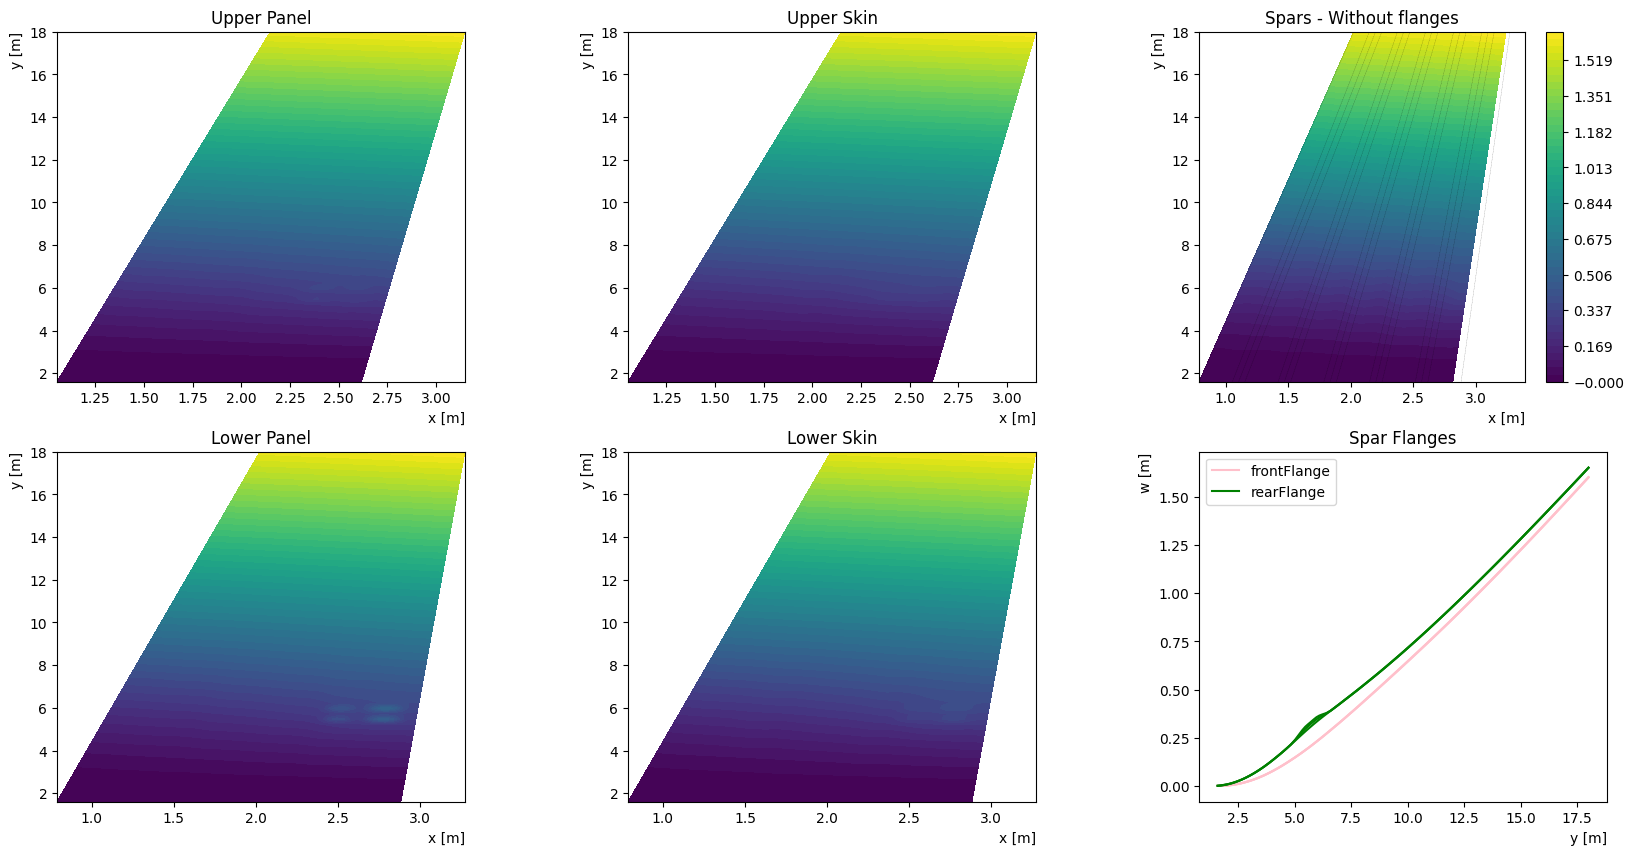

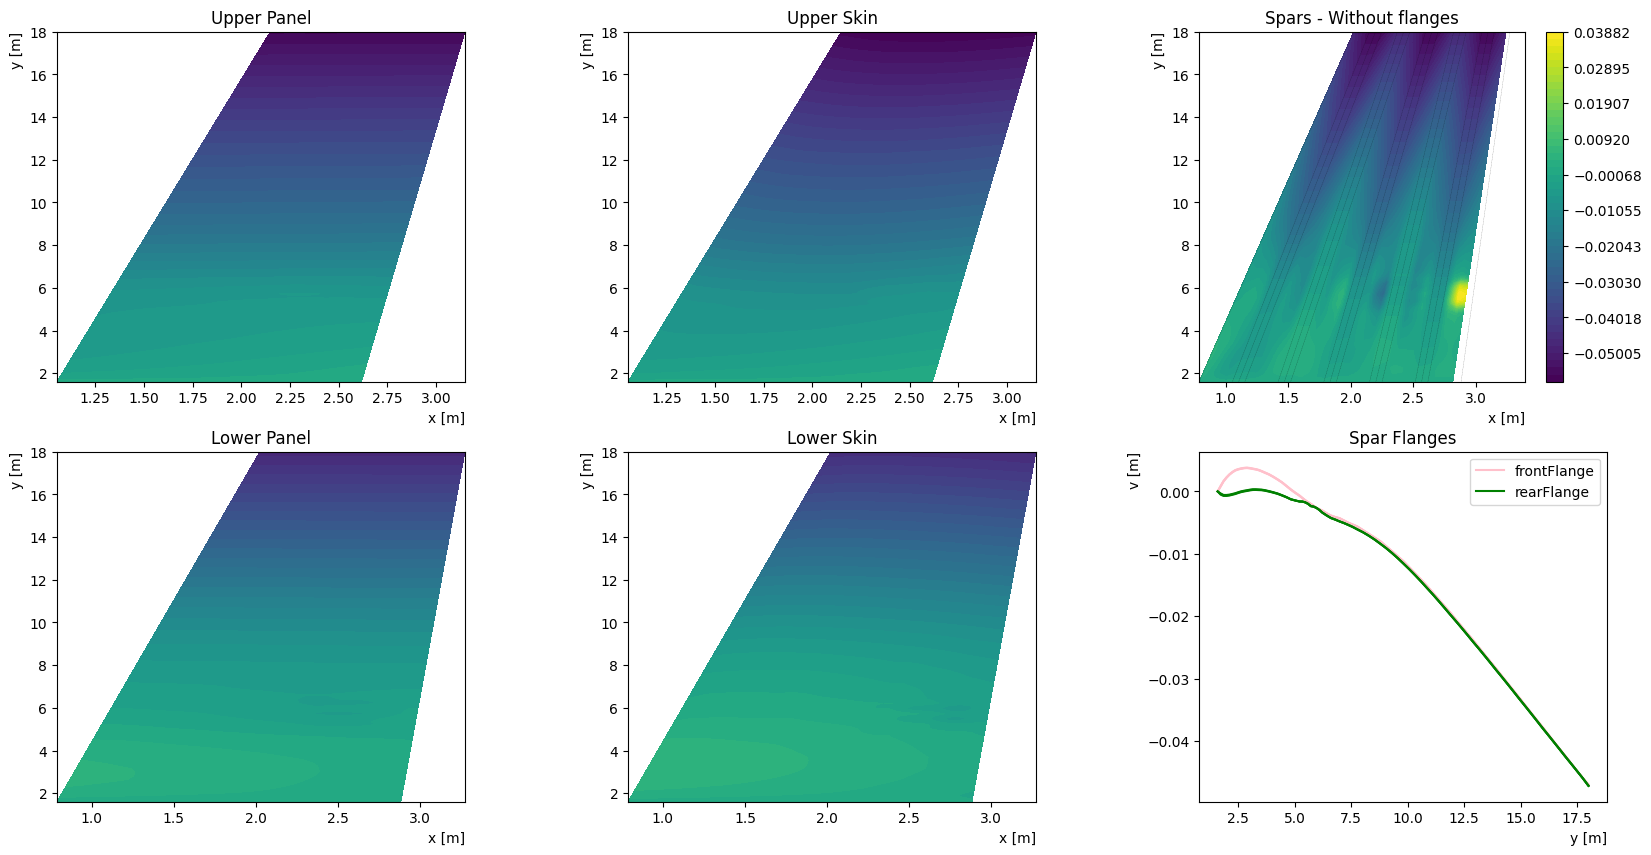

In [6]:
'''Standard deflection plots to check the solution's quality'''
wfig = bl.plot_block(sol['w'], "w", meshOut, csts)
vfig = bl.plot_block(sol['v'], "v", meshOut, csts)

# Post Processor - internal forces and margins for every failure mode

In [8]:
def flutter_block(consts:ty.Dict[str, object], meshOuts:ty.Dict[str, object], lc:ty.Dict[str, object], sol:ty.Dict[str, object]):
    les, tes, up, M, N = [meshOuts[k] for k in ["les", "tes", "up", "M", "N"]]
    foils, bres, cres, velocities, airfs = [consts[k] for k in ["FOILS", "BRES", "CRES", "VELOCITIES", "FOILS"]]
    op, nlg = [lc[k] for k in ["op", "nlg"]]
    ncoords_s, ids_s, bu, Kuu = [sol[k] for k in ["ncoords_s", "ids_s", "bu", "KC0uu"]]
    airplane, vlm, forces, moments = ls.vlm(les, tes, airfs, op, bres, cres, np.zeros(len(airfs)))
    W, Fext = ls.aero2fem(vlm, ncoords_s, ids_s, N, pf3.DOF)
    W_u_to_p = ls.fem2aero(les, np.zeros(len(foils)), ncoords_s, ids_s, N, pf3.DOF)

    #natural freqs for flutter
    return ls.flutter_omegans(velocities, M, bu, W_u_to_p, Kuu, W, les, tes, airfs, op, up.fft.y, bres, cres)


In [ ]:
def rotate_2_local(ele, id_node, ncoords):
    xg, yg, zg = ncoords[id_node]
    xe = ele.r11*xg+ele.r21*yg+ele.r31*zg
    ye = ele.r12*xg+ele.r22*yg+ele.r32*zg
    ze = ele.r13*xg+ele.r23*yg+ele.r33*zg
    return xe, ye, ze

def quad_plate_stress(ele, finte_part, wxe, wye):
    Fxe, Fye, Fze, Mxe, Mye, Mze = np.asanyarray(finte_part)

    #plane stresses
    sx = Fxe/wye/ele.shellprop.h
    sy = Fye/wxe/ele.shellprop.h
    sxC = sx-abs(Mye/(wye*ele.shellprop.h**2/12)/2)
    sxT = sx+abs(Mye/(wye*ele.shellprop.h**2/12)/2)
    syC = sy-abs(Mxe/(wxe*ele.shellprop.h**2/12)/2)
    syT = sy+abs(Mxe/(wxe*ele.shellprop.h**2/12)/2)

    #out-of-plane stresses TODO verify
    tz = np.abs(Fze)/min(wye, wxe)/ele.shellprop.h #we make the worse wall assumption, that the shear flows in a different direction than we might want it to 
    #for now, we assume no modification due to Mze TODO add that
    return np.array([sxC, sxT, syC, syT, tz, sx, sy]) #we keep sx, sy for future mohr circle caluclations


'''COPYPASTE THIS TO blocks.py ONCE DONE!!!'''
def stress_block(defl:ty.Dict[str, nt.NDArray[np.float64]], meshOuts:ty.Dict[str,object], 
                         codes:ty.Dict[str,str], sizerVals:ty.Dict[str,str], consts:ty.Dict[str,object]):
    rfl, din = tuple(consts[k] for k in ['RIB_FLANGE', 'DIN'])
    tsp, tsk, trb, tpl = tuple(sizerVals[k] for k in ['tspar', 'tskin', 'trib', 'tpan'])
    KC0, M, N, x, y, z, mesh, up, ids, pts, nid_pos, ncoords = tuple(meshOuts[k] for k in ['KC0', 'M', 'N', 'x', 'y', 'z', 'mesh', 'up', 'ids', 'pts', 'nid_pos', 'ncoords'])
    eleDict, KGv, KGr, KGc, ncoords_flatten = tuple(meshOuts[k] for k in ['elements', 'KGv', 'KGr', 'KGc', 'ncoords_flatten'])
    fi = np.zeros(meshOuts["N"])
    u, bu, bk, Kuu = tuple(defl[k] for k in ["u", "bu", "bk", "KC0uu"])

    '''INTERNAL LOADS'''
    #only for quads and beams as of now - that's all we are using
    sigma_most = {'quad':{codes["skin"]:[], codes["panelRib"]:[], codes["panelPlate"]:[], codes["spar"]:[]},
                'beam':{codes["rail"]:[], codes["panelFlange"]:[]}}
    tau_most = {'quad':{codes["skin"]:[], codes["panelRib"]:[], codes["panelPlate"]:[], codes["spar"]:[]},
                'beam':{codes["rail"]:[], codes["panelFlange"]:[]}}
    sorted_eles = {'quad':{codes["skin"]:[], codes["panelRib"]:[], codes["panelPlate"]:[], codes["spar"]:[]},
                'beam':{codes["rail"]:[], codes["panelFlange"]:[]}}
    for quad in eleDict["quad"]:
        # NOTE update affects the Quad4RProbe class attribute ue
        quad.update_probe_xe(ncoords_flatten)
        quad.update_probe_ue(u)
        quad.update_KG(KGr, KGc, KGv, quad.shellprop)
        quad.update_probe_finte(quad.shellprop)
        quad.update_fint(fi, quad.shellprop)

        "stresses"
        #transferring nodes into local coord system
        xe1, ye1, ze1 = rotate_2_local(quad, nid_pos[quad.n1], ncoords)
        xe2, ye2, ze2 = rotate_2_local(quad, nid_pos[quad.n2], ncoords)
        xe3, ye3, ze3 = rotate_2_local(quad, nid_pos[quad.n3], ncoords)
        xe4, ye4, ze4 = rotate_2_local(quad, nid_pos[quad.n4], ncoords)

        #getting the widths of the element - we have some very elongated element, so necessary to consider
        #current algorithm is wxe*wye=SA, wxe~max(xes)-min(xes), wyeb similarly
        #area by two cross products
        SA = .5*np.linalg.norm(np.cross([xe4-xe1, ye4-ye1, ze4-ze1], [xe2-xe1, ye2-ye1, ze2-ze1]))+.5*np.linalg.norm(np.cross([xe1-xe2, ye1-ye2, ze1-ze2], [xe3-xe2, ye3-ye2, ze3-ze2]))
        wxeprop=max(xe1, xe2, xe3, xe4)-min(xe1, xe2, xe3, xe4)
        wyeprop=max(ye1, ye2, ye3, ye4)-min(ye1, ye2, ye3, ye4)
        c = np.sqrt(SA/wxeprop/wyeprop)
        wxe = wxeprop*c
        wye = wyeprop*c

        #stress calculation for the four nodes - then averaged
        stresses1 = quad_plate_stress(quad, quad.probe.finte[:6], wxe, wye)
        stresses2 = quad_plate_stress(quad, quad.probe.finte[6:12], wxe, wye)
        stresses3 = quad_plate_stress(quad, quad.probe.finte[12:18], wxe, wye)
        stresses4 = quad_plate_stress(quad, quad.probe.finte[18:], wxe, wye)
        stresses = (stresses1+stresses2+stresses3+stresses4)/4

        #further individual post-processing and saving of the results
        if quad.eleid == codes["skin"]:
            tau_most["quad"][codes["skin"]].append(stresses[4])
            sigma_most["quad"][codes["skin"]].append(max(np.abs(stresses[:4])))
            sorted_eles["quad"][codes["skin"]].append(quad)

        elif quad.eleid == codes["panelRib"]:
            tau_most["quad"][codes["panelRib"]].append(stresses[4])
            sigma_most["quad"][codes["panelRib"]].append(max(np.abs(stresses[:4])))
            sorted_eles["quad"][codes["panelRib"]].append(quad)

        elif quad.eleid == codes["panelPlate"]:
            tau_most["quad"][codes["panelPlate"]].append(stresses[4])
            sigma_most["quad"][codes["panelPlate"]].append(max(np.abs(stresses[:4])))
            sorted_eles["quad"][codes["panelPlate"]].append(quad)

        elif quad.eleid == codes["spar"]:
            tau_most["quad"][codes["spar"]].append(stresses[4])
            sigma_most["quad"][codes["spar"]].append(max(np.abs(stresses[:4])))
            sorted_eles["quad"][codes["spar"]].append(quad)

        else: raise NotImplementedError(f"A quad element of eleid {quad.eleid} not accounted for in post-processing!")

    for beam in eleDict["beam"]:
        beam.update_probe_xe(ncoords_flatten)
        beam.update_probe_ue(u)
        beam.update_KG(KGr, KGc, KGv, beam.beamprop, 0) #here only values change
        beam.update_probe_finte(beam.beamprop)
        beam.update_fint(fi, beam.beamprop) 

        "stresses"
        Fx1, Fy1, Fz1, Mx1, My1, Mz1 = beam.probe.finte[:6]

        A, J, Iyy, Izz = beam.beamprop.A, beam.beamprop.J, beam.beamprop.Iyy, beam.beamprop.Izz 

        if beam.eleid == codes["rail"]:
            #normal stress
            sigma_most["beam"][codes["rail"]].append(abs(Fx1)/A+din/2*np.sqrt((Mz1/Izz)**2+(My1/Iyy)**2))
                                                     
            #shear stress - we have to run a maximalisation problem for every node
            radius_fun = lambda xe:xe[0]**2+xe[1]**2
            rad_constr = opt.NonlinearConstraint(radius_fun, -1e-6, din**2/4) #TODO: add actual jacobian
            #negative to use minimise
            shearsq_fun1 = lambda xe: -(Mx1*xe[1]/J+Fy1/3/Izz*(din**2/4-xe[0]**2))**2-(Mx1*xe[0]/J+Fz1/3/Iyy*(din**2/4-xe[1]**2))**2
            shearsq1 = opt.minimize(shearsq_fun1, np.array([0,0]), constraints=[rad_constr],
                                    method="Cobyla")
            print(shearsq1)
            tau_most["beam"][codes["rail"]].append(np.sqrt(-shearsq1.fun)) #back to actual shear stress

            #saving the element in a matching format
            sorted_eles["beam"][codes["rail"]].append(beam)

        elif beam.eleid == codes["panelFlange"]:
            #most constraining normal stress in when bending stresses are in the same direction as axial stress
            #! For isotropic materials only!
            sigma_most["beam"][codes["panelFlange"]].append(abs(Fx1)/A+(abs(My1)/Iyy*trb/2+abs(Mz1)/Izz*rfl/2))

            #most constraining shear stress - either one of the sides with torsion of the middle
            def tau_most_at_node(Mx, Fy, Fz):
                tau_Mx = abs(Mx)*(3+1.8*trb/rfl)/rfl/trb**2 #directions don't matter, we can get all combinations
                tau_Fz = abs(Fz)*trb**2/8/Iyy
                tau_Fy = abs(Fy)*rfl**2/8/Izz
                return max(tau_Mx+tau_Fz, tau_Mx+tau_Fy, np.sqrt(tau_Fy**2+tau_Fz**2))
            tau_most["beam"][codes["panelFlange"]].append(tau_most_at_node(Mx1, Fy1, Fz1))

            #saving the element in a matching format
            sorted_eles["beam"][codes["panelFlange"]].append(beam)

        else: raise NotImplementedError(f"A beam element of eleid {quad.eleid} not accounted for in post-processing!")
          
    fi[bk] = 0 #to avoid internal force at clamps which can be latge and are weirdly defined

    return sorted_eles, tau_most, sigma_most, fi

def eigen_analysis_block(defl:ty.Dict[str, nt.NDArray[np.float64]], meshOuts:ty.Dict[str,object], 
                         codes:ty.Dict[str,str], sizerVals:ty.Dict[str,str], consts:ty.Dict[str,object]):
    rfl, din = tuple(consts[k] for k in ['RIB_FLANGE', 'DIN'])
    tsp, tsk, trb, tpl, v0b, v0f = tuple(sizerVals[k] for k in ['tspar', 'tskin', 'trib', 'tpan', 'v0b', 'v0f'])
    KC0, M, N, x, y, z, mesh, up, ids, pts = tuple(meshOuts[k] for k in ['KC0', 'M', 'N', 'x', 'y', 'z', 'mesh', 'up', 'ids', 'pts'])
    eleDict, KGv, KGr, KGc, ncoords_flatten = tuple(meshOuts[k] for k in ['elements', 'KGv', 'KGr', 'KGc', 'ncoords_flatten'])
    u, bu, bk, Kuu, KAuu = tuple(defl[k] for k in ["u", "bu", "bk", "KC0uu", "KAuu"])

    if v0b is None:
        v0b = np.zeros(N)
        v0bu = v0b[bu]
        v0bu[0] = 1.
    else:
        v0bu = v0b[bu]
    if v0f is None:
        v0f = u.copy()
    v0fu = v0f[bu]

    '''BUCKLING ANALYSIS'''
    KG = ss.coo_matrix((KGv, (KGr, KGc)), shape=(N, N)).tocsc()
    KGuu = KG[bu, :][:, bu]
    num_eig_lb = 4 #TODO: for now
    eigvecs = np.zeros((N, num_eig_lb))
    print("buckling eigs started")
    eigvals, eigvecsu = ssl.eigsh(A=KGuu, k=num_eig_lb, which="SM", M=Kuu-KAuu, tol=1e-15, sigma=1., mode="cayley", v0=v0b)
    print("buckling eigs ended")
    eigvals = -1./eigvals
    eigvecs[bu] = eigvecsu
    load_mult = eigvals[0] #TODO from what it seems to me has to be strictly greater than one
    print("buckling interpreted")

    '''EIGENFREQUENCY ANALYSIS'''
    Muu = M[bu, :][:, bu]
    num_eig=6 #TODO: for now
    eigvecsO = np.zeros((N, num_eig))
    print("flutter eigs started")
    eigvalsO, eigvecsuO = ssl.eigs(A=Kuu-KAuu, M=Muu, sigma=-1., which='LM',
            k=num_eig, tol=1e-5, v0=v0f)
    print("flutter eigs ended")
    eigvecsO[bu] = eigvecsuO
    omegan = eigvalsO**0.5
    print("flutter interpreted")

    return KG, KGuu, load_mult, eigvecs, eigvals, omegan

'A WRAPPER FUNCTION FOR ALL POST-PROCESSING'    
def post_processor_block(defl:ty.Dict[str, nt.NDArray[np.float64]], meshOuts:ty.Dict[str,object], 
                         codes:ty.Dict[str,str], sizerVals:ty.Dict[str,str], consts:ty.Dict[str,object]):
    
    sorted_eles, tau_most, sigma_most, fi = stress_block(defl, meshOuts, codes, sizerVals, consts)
    KG, KGuu, load_mult, eigvecs, eigvals, omegan = eigen_analysis_block(defl, meshOuts, codes, sizerVals, consts)

    return {"elements":sorted_eles, "fi":fi, "KG":KG, "KGuu":KGuu, "load_mult":load_mult, "eigvecs":eigvecs, "eigvals":eigvals, "omegan":omegan,
            "sigma":sigma_most, "tau":tau_most}

## Stress

Here be code just for stress sub-block testing

In [18]:
sorted_eles, tau_most, sigma_most, fi = stress_block(sol, meshOut, cst.CODES, cst.INITIAL, cst.CONSTS)


 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -153455579143581.75
       x: [-7.500e-03  1.178e-04]
    nfev: 36
   maxcv: 2.0177442773117833e-08
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -61089582628738.336
       x: [ 7.501e-03  6.954e-05]
    nfev: 40
   maxcv: 1.9921848098853896e-08
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -8214936672938.448
       x: [ 7.501e-03  5.760e-05]
    nfev: 38
   maxcv: 1.9700046784139433e-08
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -32718298566956.56
       x: [ 7.501e-03 -4.387e-05]
    nfev: 42
   maxcv: 2.009847419297549e-08
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2232207844690.7246
       x: [-1.023e-03 -7.431e-03]
    nfev: 44
   maxcv: 1.9945717049994576e-08
 message: Optimization terminated successfully.
 success: True
  status: 1
   

In [19]:
for r in sorted_eles["quad"][cst.CODES["panelPlate"]]:
    if not np.isclose(np.asanyarray(r.probe.finte).sum(), 0):
        print(np.asanyarray(r.probe.finte))

[ 3.47206347e+04  2.09304936e+04  4.96422986e+02  6.42009485e+00
 -4.66432705e-02  0.00000000e+00 -1.17841698e+04  5.47214907e+03
  5.15333067e+02  6.38141733e+00 -1.30676453e-01 -1.32447214e-01
 -2.59465285e+04 -9.51541668e+03 -4.96422986e+02  6.13026824e+00
  5.50648757e-01 -7.37257477e-17  3.01006355e+03 -1.68872260e+04
 -5.15333067e+02  6.30656684e+00  4.22552431e-01  0.00000000e+00]
[ 3.25782683e+04  1.93416440e+04 -5.49300040e+02 -9.50721653e+00
 -9.19302657e+00  0.00000000e+00 -7.71403742e+03  5.29894911e+03
 -8.47169663e+02 -1.04753339e+01 -9.33966097e+00 -7.58941521e-17
 -2.57935020e+04 -9.73249236e+03  5.49300040e+02 -7.01750163e+00
 -9.07810325e+00 -1.22396384e-01  9.29271089e+02 -1.49081008e+04
  8.47169663e+02 -7.83501234e+00 -9.00609608e+00  0.00000000e+00]
[ 5.42196683e+04  2.78192086e+04 -5.67731383e+02 -1.05019231e+01
  1.29391507e+01  0.00000000e+00 -1.87616963e+04  9.93122654e+03
 -1.89912291e+02 -1.04477468e+01  1.31253673e+01 -1.22396384e-01
 -5.17135815e+04 -2.408

In [20]:
import pyvista
pyvista.set_plot_theme('document')
pyvista.set_jupyter_backend('trame')
pyvista.global_theme.window_size = [600, 400]
pyvista.global_theme.axes.show = True
pyvista.global_theme.anti_aliasing = 'fxaa'
pyvista.global_theme.show_scalar_bar = True

In [21]:
print("BEAMS:")
print(f"sigma rail: max: {max(sigma_most["beam"][cst.CODES["rail"]])}, min:{min(sigma_most["beam"][cst.CODES["rail"]])}")
print(f"tau rail: max: {max(tau_most["beam"][cst.CODES["rail"]])}, min:{min(tau_most["beam"][cst.CODES["rail"]])}")
print(f"sigma flange: max: {max(sigma_most["beam"][cst.CODES["panelFlange"]])}, min:{min(sigma_most["beam"][cst.CODES["panelFlange"]])}")
print(f"tau flange: max: {max(tau_most["beam"][cst.CODES["panelFlange"]])}, min:{min(tau_most["beam"][cst.CODES["panelFlange"]])}")
print("\nQUADS:")
print(f"tau rib: max: {max(tau_most["quad"][cst.CODES["panelRib"]])}, min:{min(tau_most["quad"][cst.CODES["panelRib"]])}")
print(f"sigma rib: max: {max(sigma_most["quad"][cst.CODES["panelRib"]])}, min:{min(sigma_most["quad"][cst.CODES["panelRib"]])}")
print(f"tau plate: max: {max(tau_most["quad"][cst.CODES["panelPlate"]])}, min:{min(tau_most["quad"][cst.CODES["panelPlate"]])}")
print(f"sigma plate: max: {max(sigma_most["quad"][cst.CODES["panelPlate"]])}, min:{min(sigma_most["quad"][cst.CODES["panelPlate"]])}")
print(f"tau skin: max: {max(tau_most["quad"][cst.CODES["skin"]])}, min:{min(tau_most["quad"][cst.CODES["skin"]])}")
print(f"sigma skin: max: {max(sigma_most["quad"][cst.CODES["skin"]])}, min:{min(sigma_most["quad"][cst.CODES["skin"]])}")
print(f"tau spar: max: {max(tau_most["quad"][cst.CODES["spar"]])}, min:{min(tau_most["quad"][cst.CODES["spar"]])}")
print(f"sigma spar: max: {max(sigma_most["quad"][cst.CODES["spar"]])}, min:{min(sigma_most["quad"][cst.CODES["spar"]])}")

BEAMS:
sigma rail: max: 2935527327.3252444, min:1303887.2873778786
tau rail: max: 184789539.8077739, min:27209.988220457195
sigma flange: max: 1716791584.2343163, min:0.0
tau flange: max: 536986404.7030412, min:0.0

QUADS:
tau rib: max: 2385171791.5760584, min:0.0
sigma rib: max: 3741727870.0740733, min:0.0
tau plate: max: 200535899.26901364, min:12204.497184089198
sigma plate: max: 5767235041.823904, min:869030.6012787065
tau skin: max: 115885937.82728228, min:2074.581308248078
sigma skin: max: 3326293061.0900426, min:1145590.6695407787
tau spar: max: 174698009.59022418, min:419.59301238332375
sigma spar: max: 1106241797.1483974, min:659852.980124657


In [22]:
import pyvista as pv

edges = []
sigmas = []
taus = []
sigma_max = max(sigma_most["beam"][cst.CODES["rail"]]+sigma_most["beam"][cst.CODES["panelFlange"]])
tau_max = max(tau_most["beam"][cst.CODES["rail"]]+tau_most["beam"][cst.CODES["panelFlange"]])
tau_argmax = np.array(tau_most["beam"][cst.CODES["rail"]]+tau_most["beam"][cst.CODES["panelFlange"]]).argmax()
print(f"Sigma_max: {sigma_max}; Tau_max: {tau_max}")

for ele, sgm, tau in zip(sorted_eles["beam"][cst.CODES["rail"]]+sorted_eles["beam"][cst.CODES["panelFlange"]],
                         sigma_most["beam"][cst.CODES["rail"]]+sigma_most["beam"][cst.CODES["panelFlange"]],
                         tau_most["beam"][cst.CODES["rail"]]+tau_most["beam"][cst.CODES["panelFlange"]]):
    ncoords, nid_pos, x,y,z = (meshOut[k] for k in ['ncoords', 'nid_pos', 'x', 'y', 'z'])
    edges.append([nid_pos[ele.n1], nid_pos[ele.n2]])
    sigmas.append((1-sgm/sigma_max))
    taus.append(tau)
    if np.isclose(tau, tau_max):
        print(x[nid_pos[ele.n1]], y[nid_pos[ele.n1]], z[nid_pos[ele.n1]])
        print(x[nid_pos[ele.n2]], y[nid_pos[ele.n2]], z[nid_pos[ele.n2]])
    
padding = np.empty(len(edges), int) * 2
padding[:] = 2
edges_w_padding = np.vstack((padding, np.array(edges).T)).T
edges_w_padding

meshpv = pv.PolyData(ncoords, edges_w_padding)
colors = np.nan_to_num(taus)
print(colors)
line_width = np.ones(len(edges))
colors[tau_argmax] = 1
meshpv.plot(scalars=taus,
            render_lines_as_tubes=True,
    style='wireframe',
    line_width=10,
    cmap='jet',
    show_scalar_bar=False,
    background='w',)

Sigma_max: 2935527327.3252444; Tau_max: 536986404.7030412
2.901153120612621 4.448177500000001 0.4154773133773187
2.9261531176569964 4.448177500000001 0.4169723392033898
[12387718.88378089  7815982.51205428  2866171.08228704 ...
  8132517.9469205   5993065.85248319  5324737.14493825]


Widget(value='<iframe src="http://localhost:51176/index.html?ui=P_0x1c38919dfa0_3&reconnect=auto" class="pyvis…

In [23]:
import pyvista as pv

edges = []
sigmas = []
taus = []
code = cst.CODES["panelFlange"]
sigma_max = max(sigma_most["beam"][code])
tau_max = max(tau_most["beam"][code])
tau_argmax = np.array(tau_most["beam"][code]).argmax()
print(f"Sigma_max: {sigma_max}; Tau_max: {tau_max}")

for ele, sgm, tau in zip(sorted_eles["beam"][code],
                         sigma_most["beam"][code],
                         tau_most["beam"][code]):
    ncoords, nid_pos, x,y,z = (meshOut[k] for k in ['ncoords', 'nid_pos', 'x', 'y', 'z'])
    edges.append([nid_pos[ele.n1], nid_pos[ele.n2]])
    sigmas.append(sgm)
    taus.append(tau)
    if np.isclose(tau, tau_max):
        print(x[nid_pos[ele.n1]], y[nid_pos[ele.n1]], z[nid_pos[ele.n1]])
        print(x[nid_pos[ele.n2]], y[nid_pos[ele.n2]], z[nid_pos[ele.n2]])
    
padding = np.empty(len(edges), int) * 2
padding[:] = 2
edges_w_padding = np.vstack((padding, np.array(edges).T)).T
edges_w_padding

meshpv = pv.PolyData(ncoords, edges_w_padding)
colors = np.nan_to_num(taus)
print(colors)
line_width = np.ones(len(edges))
colors[tau_argmax] = 1
meshpv.plot(scalars=taus,
            render_lines_as_tubes=True,
    style='wireframe',
    line_width=10,
    cmap='jet',
    show_scalar_bar=True,
    background='w',)

Sigma_max: 1716791584.2343163; Tau_max: 536986404.7030412
2.901153120612621 4.448177500000001 0.4154773133773187
2.9261531176569964 4.448177500000001 0.4169723392033898
[38648330.25399742 14640433.82190193 15725975.56871453 ...
  8132517.9469205   5993065.85248319  5324737.14493825]


Widget(value='<iframe src="http://localhost:51176/index.html?ui=P_0x1c3e3e64830_4&reconnect=auto" class="pyvis…

In [24]:
import pyvista as pv
pl = pv.Plotter()
ncoords, nid_pos, x,y,z = (meshOut[k] for k in ['ncoords', 'nid_pos', 'x', 'y', 'z'])
conns = list()
code = cst.CODES["spar"]

for quad in sorted_eles["quad"][code]:
    conns+=[4, nid_pos[quad.n1], nid_pos[quad.n2], nid_pos[quad.n3], nid_pos[quad.n4]]

conns = np.array(conns)
types = [pv.CellType.QUAD]*len(sorted_eles["quad"][code])

pl.show_axes()
pl.add_mesh(pv.UnstructuredGrid(conns, types, ncoords), scalars=sigma_most["quad"][code])
pl.add_scalar_bar()
pl.show()

Widget(value='<iframe src="http://localhost:51176/index.html?ui=P_0x1c3e3e67530_5&reconnect=auto" class="pyvis…

In [9]:
import matplotlib.pyplot as plt
plt.plot(cst.CONSTS["VELOCITIES"], flutter_block(cst.CONSTS, meshOut, load_case, sol))

: 

## full tests

In [ ]:
ppd = post_processor_block(sol, meshOut, cst.CODES, cst.INITIAL, cst.CONSTS)


 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -175258796541084.97
       x: [-7.500e-03 -1.182e-04]
    nfev: 43
   maxcv: 1.9701475480235866e-08
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -86494006793205.33
       x: [ 7.501e-03 -7.066e-05]
    nfev: 42
   maxcv: 2.046307845533882e-08
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3325913044936.4814
       x: [-7.501e-03 -8.112e-05]
    nfev: 38
   maxcv: 2.004567711968259e-08
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -60183183026633.78
       x: [ 7.501e-03 -6.308e-06]
    nfev: 56
   maxcv: 1.9926204654009585e-08
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3440405117005.91
       x: [-1.372e-04 -7.500e-03]
    nfev: 43
   maxcv: 2.0054540101889463e-08
 message: Optimization terminated successfully.
 success: True
  status: 1
     f

[3.59661042e-02 1.69140801e-01 2.49799099e-01 1.16412247e+02]
0.03596610418986077
[0.84150188 0.84442847 0.85328101 0.85345037 0.85493689 0.85803517]


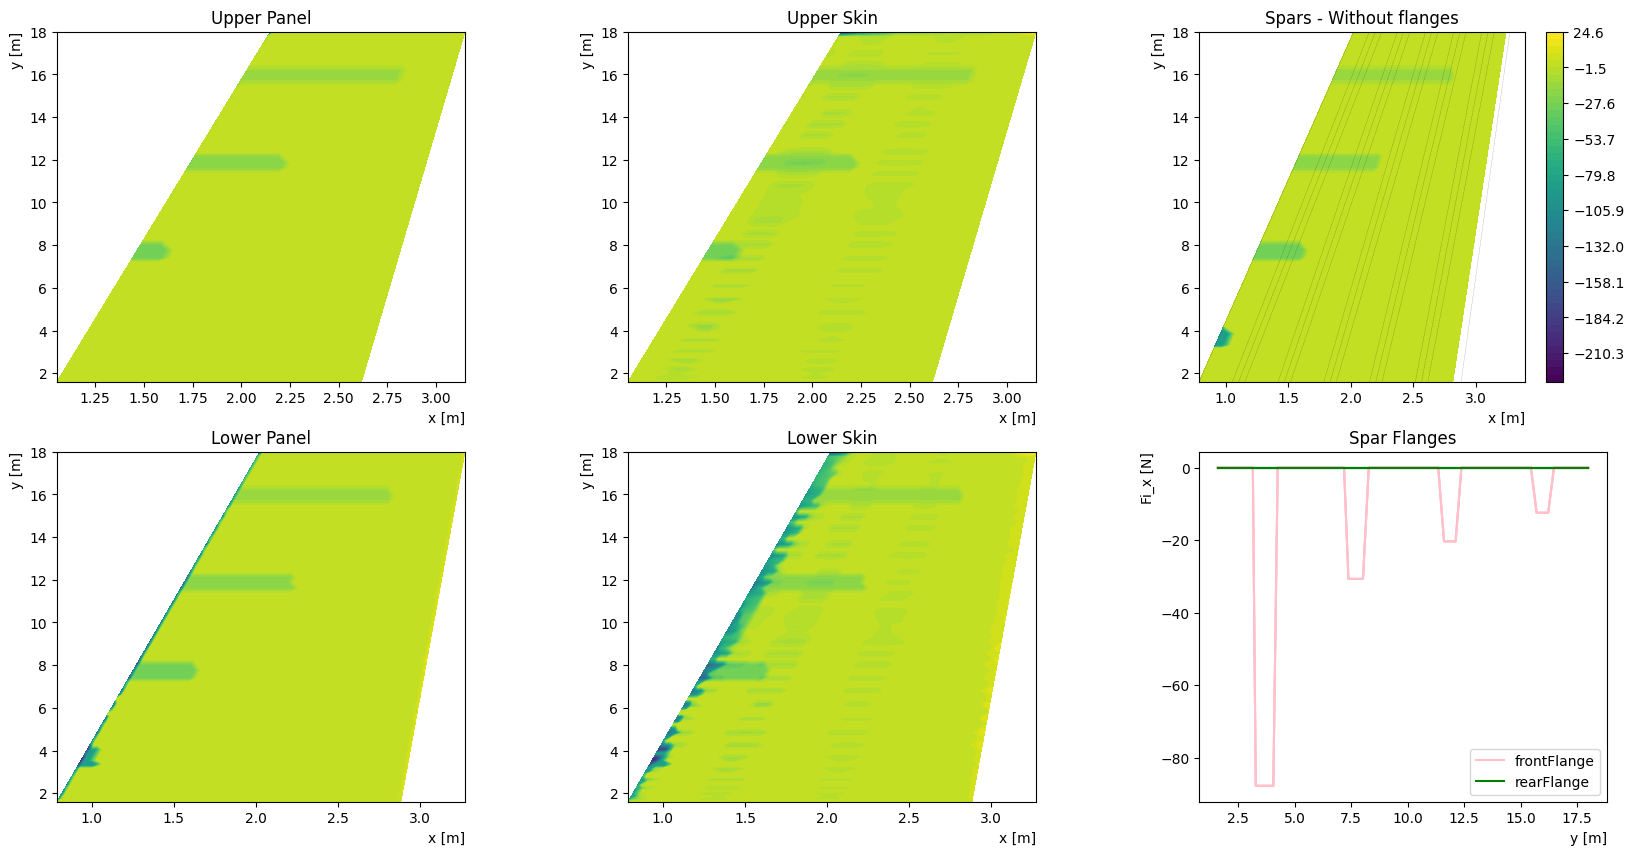

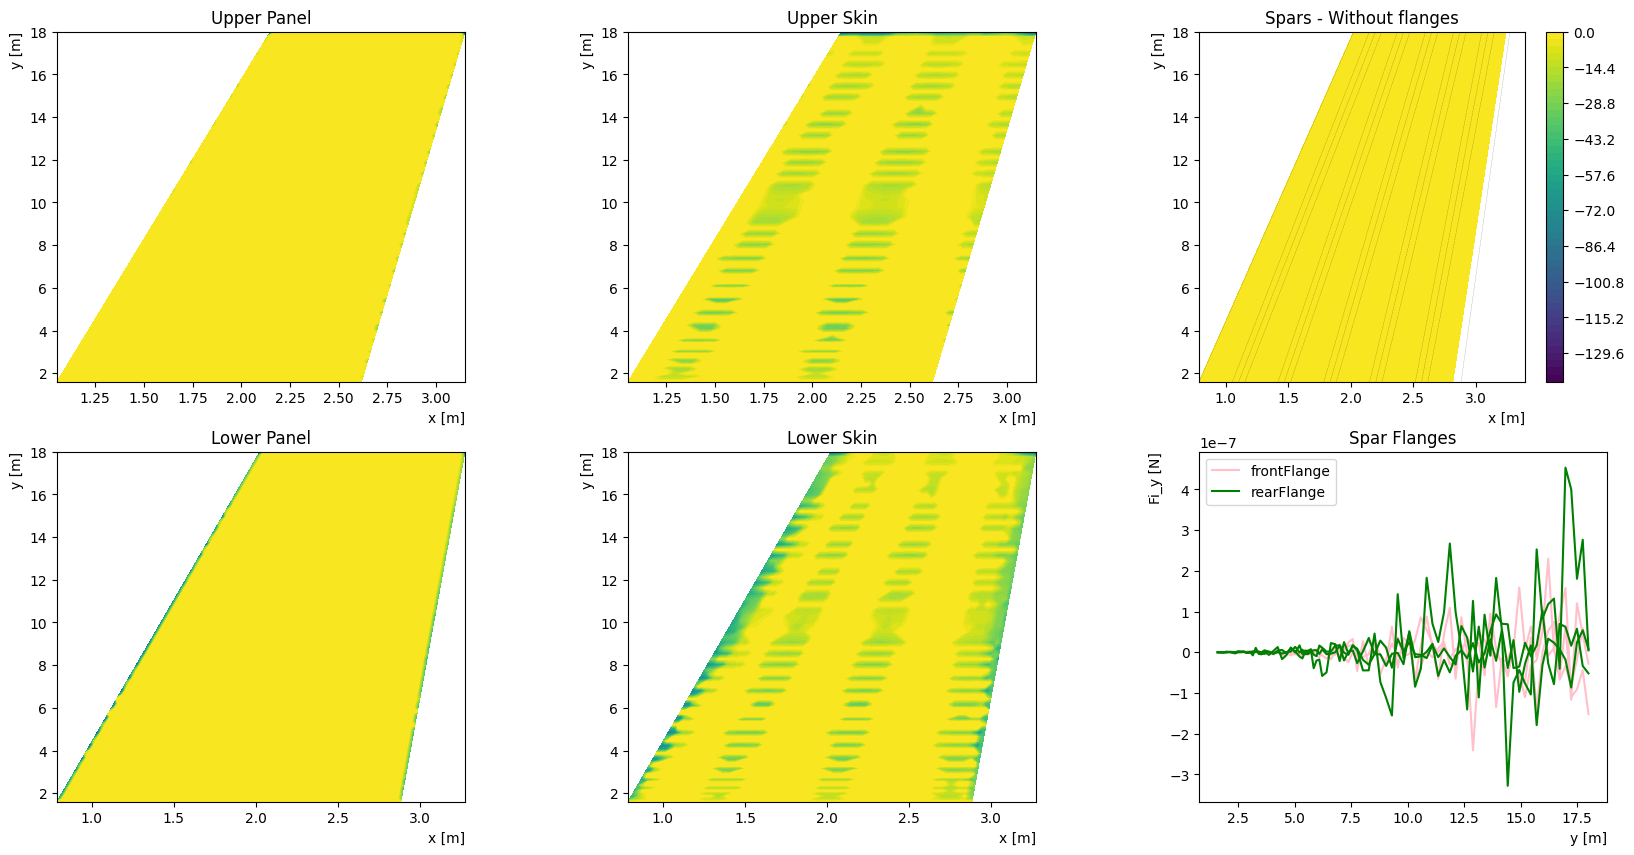

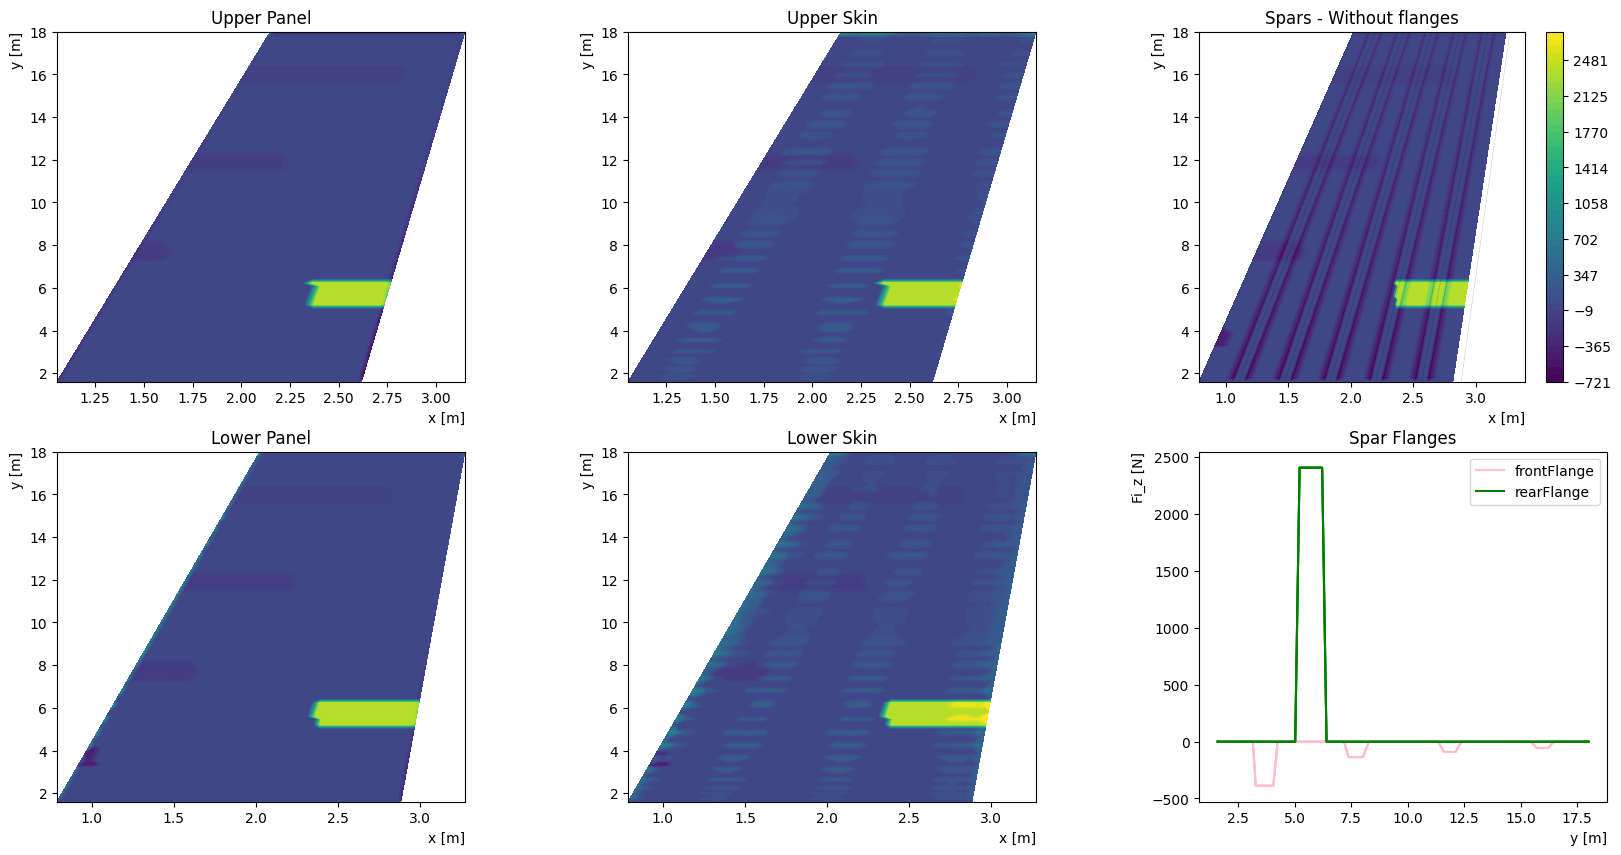

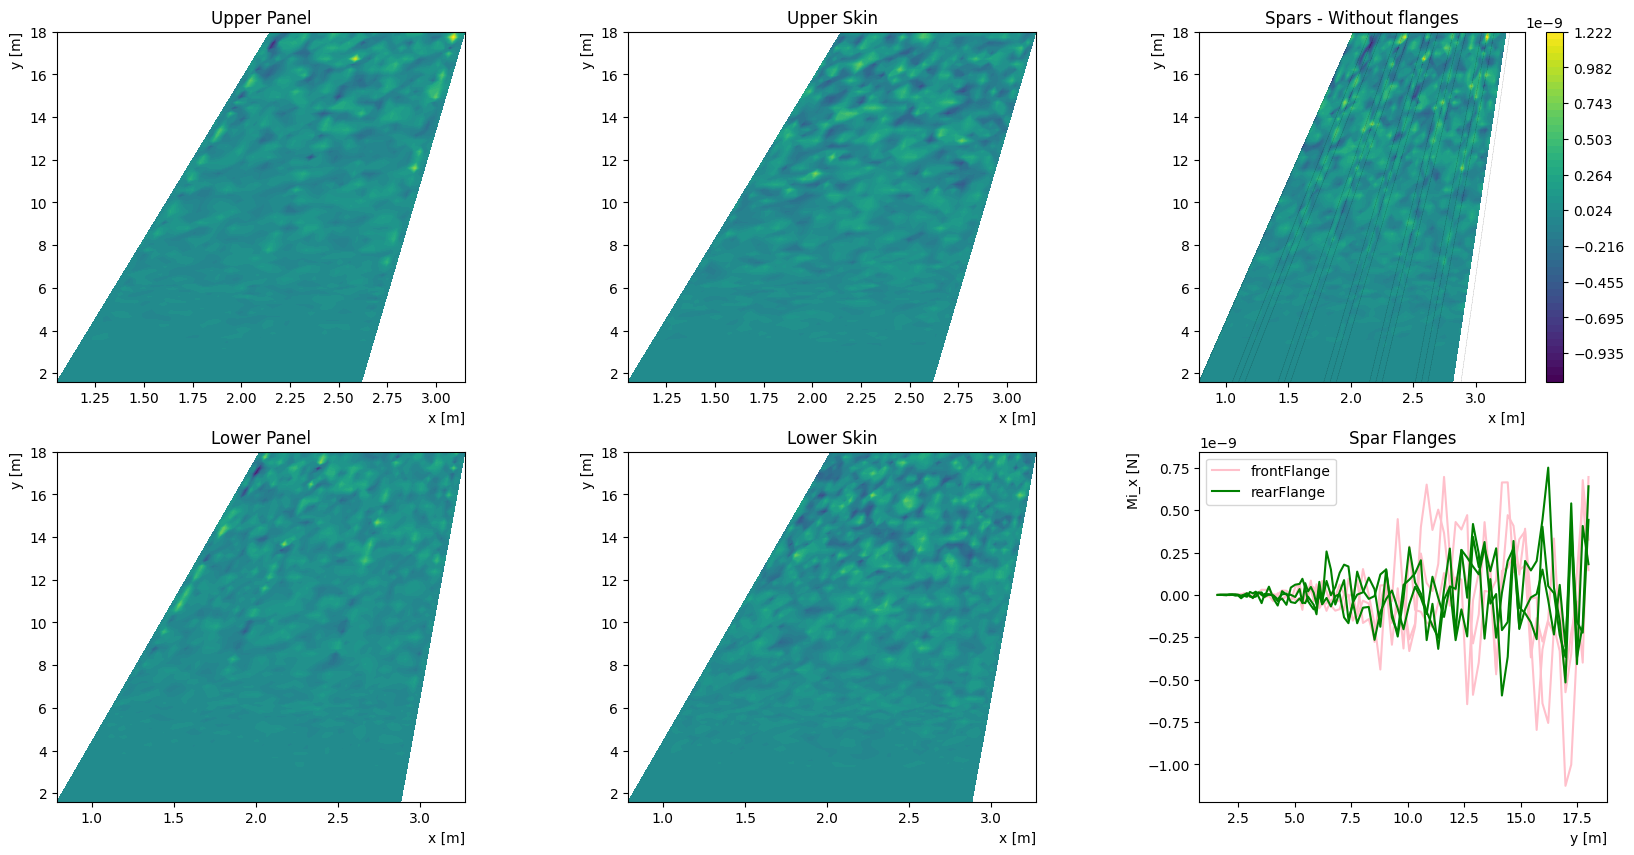

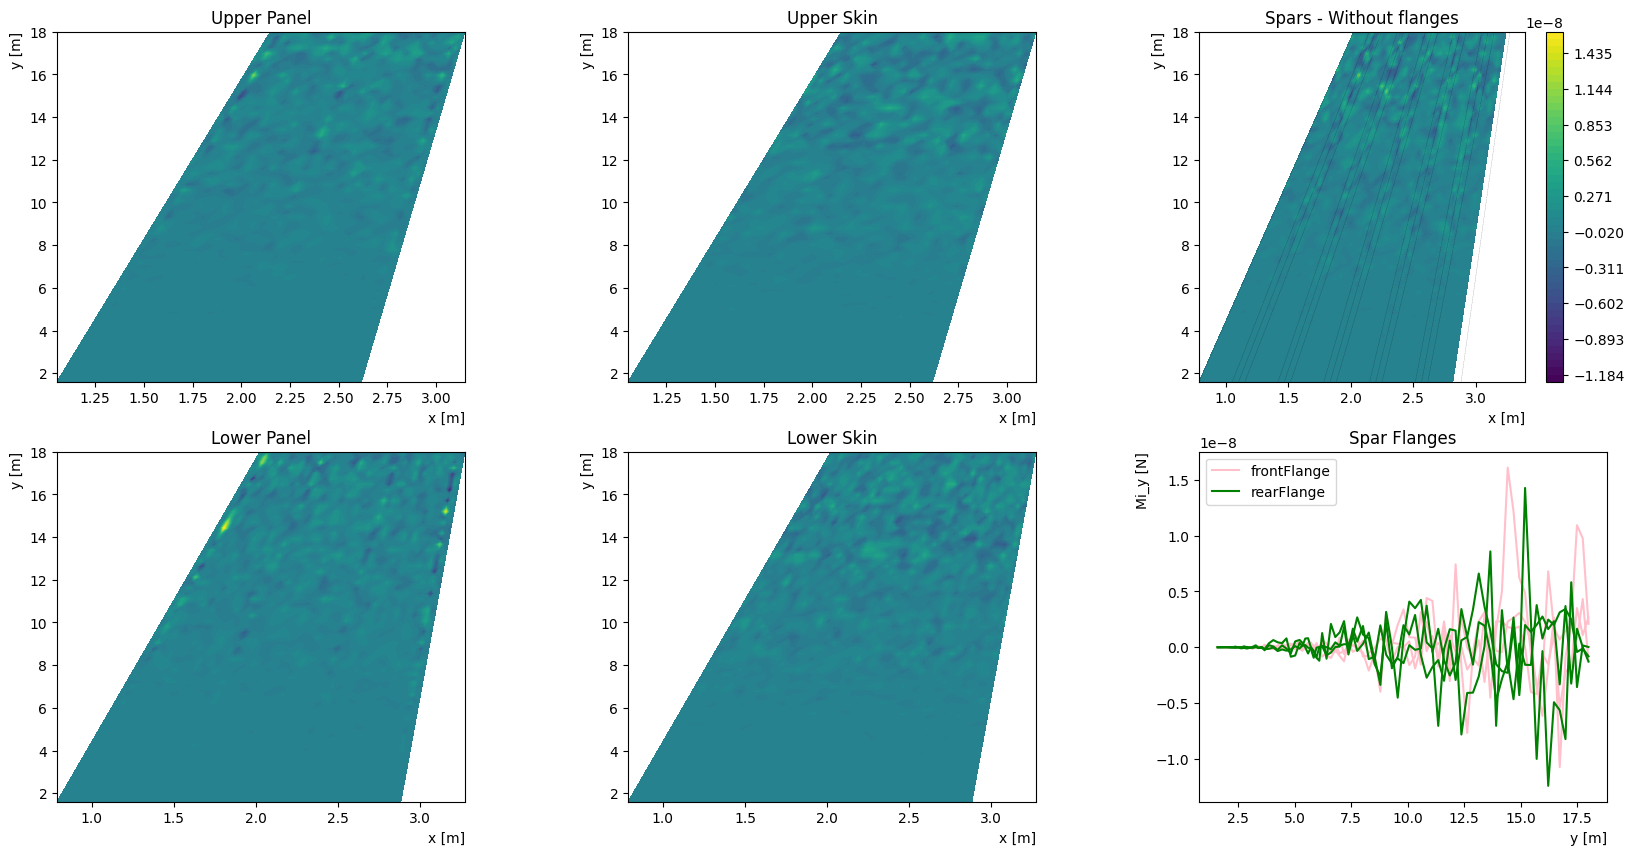

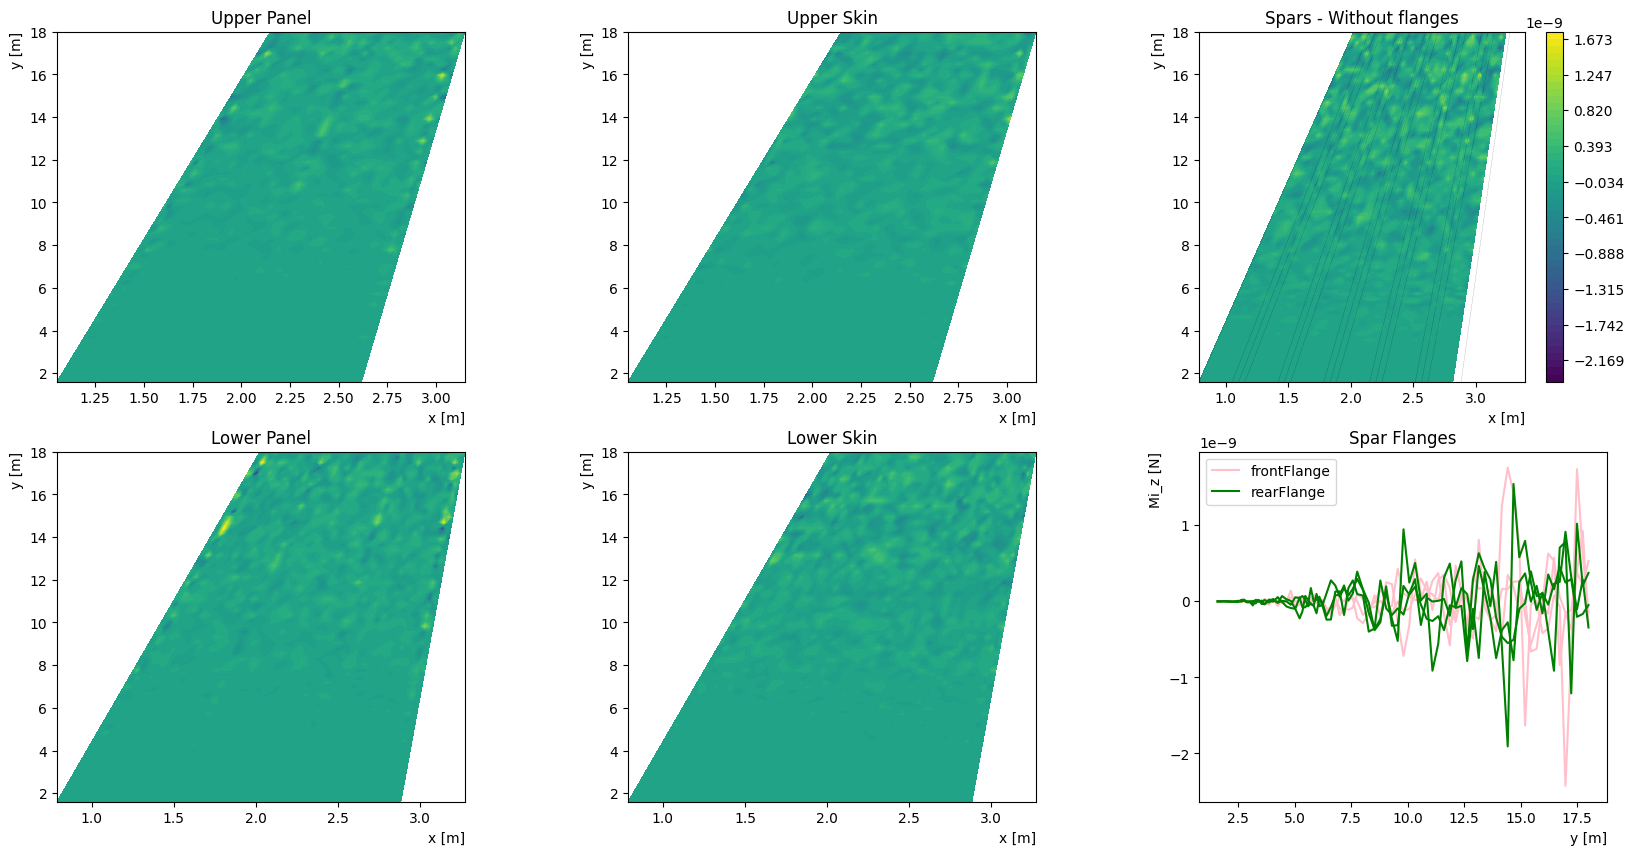

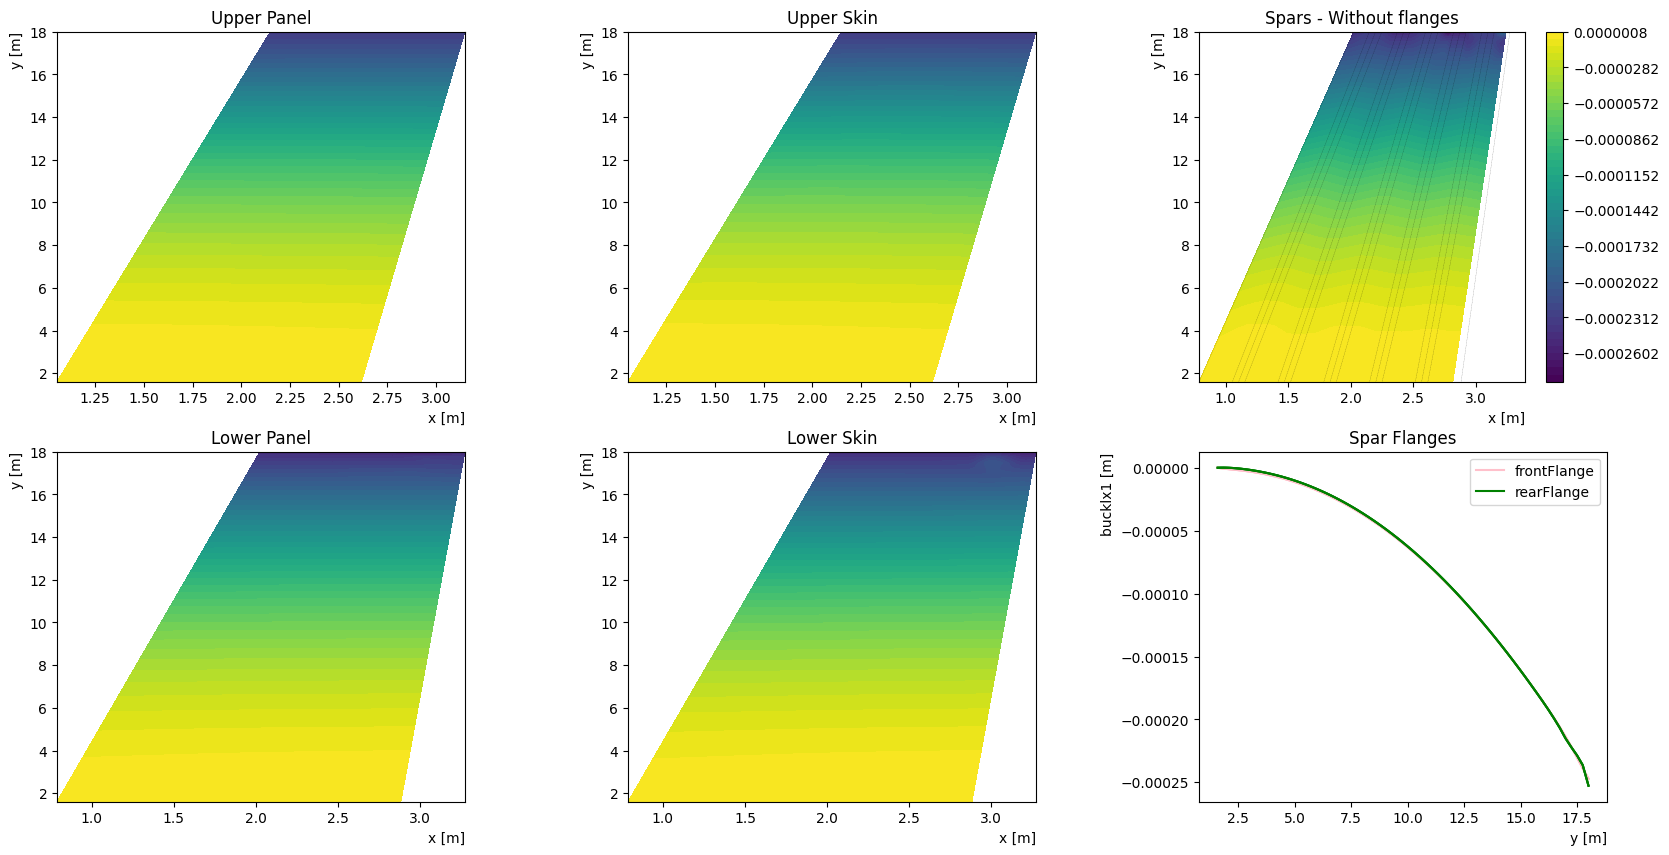

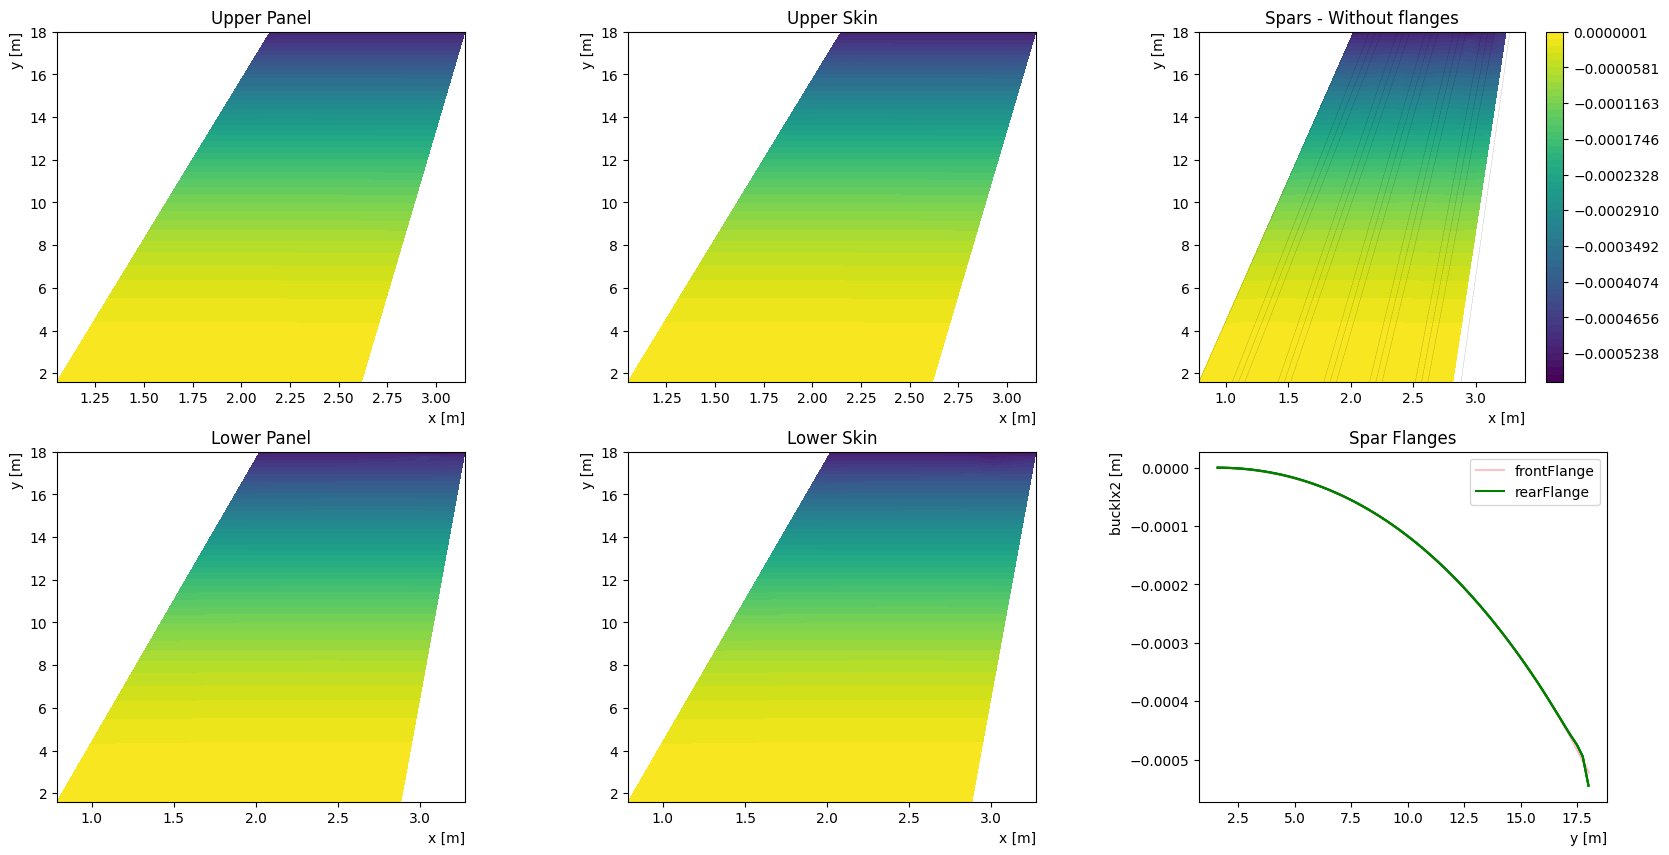

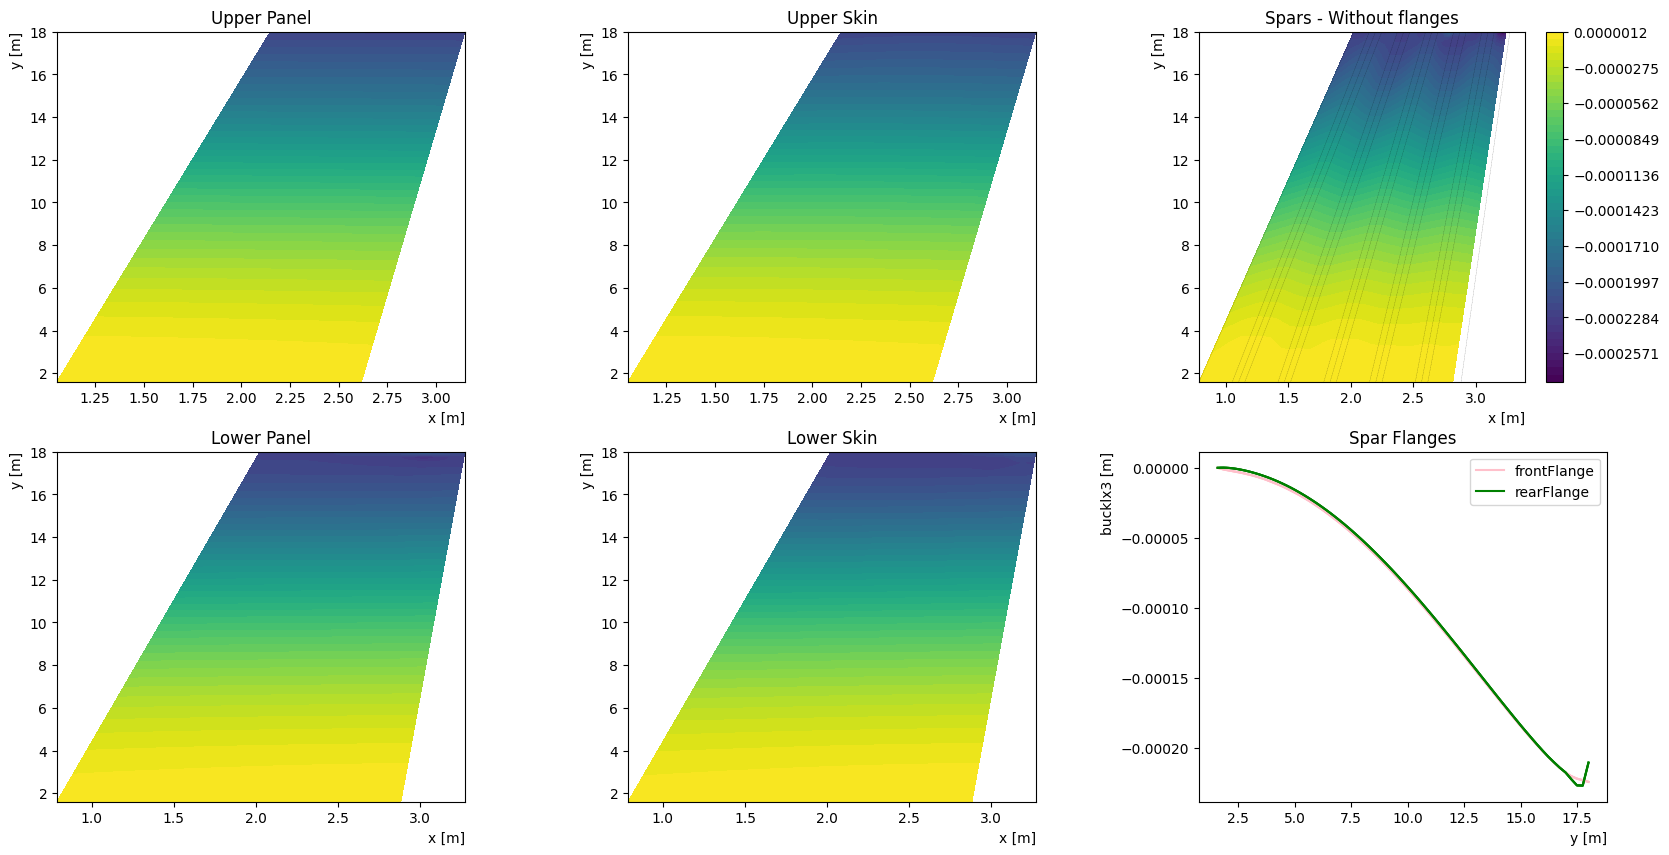

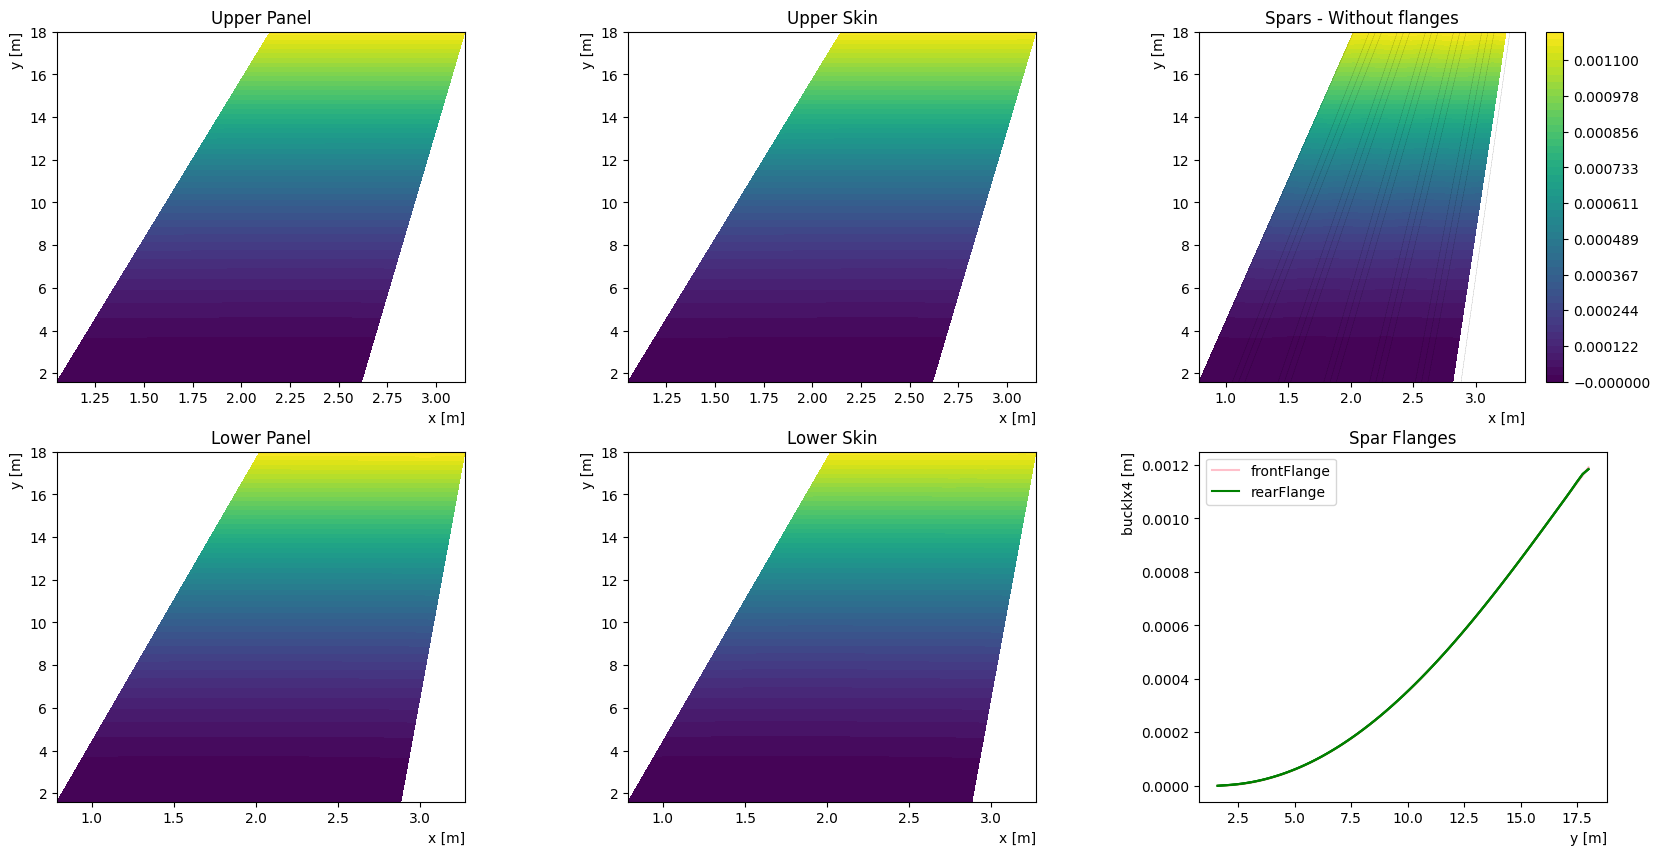

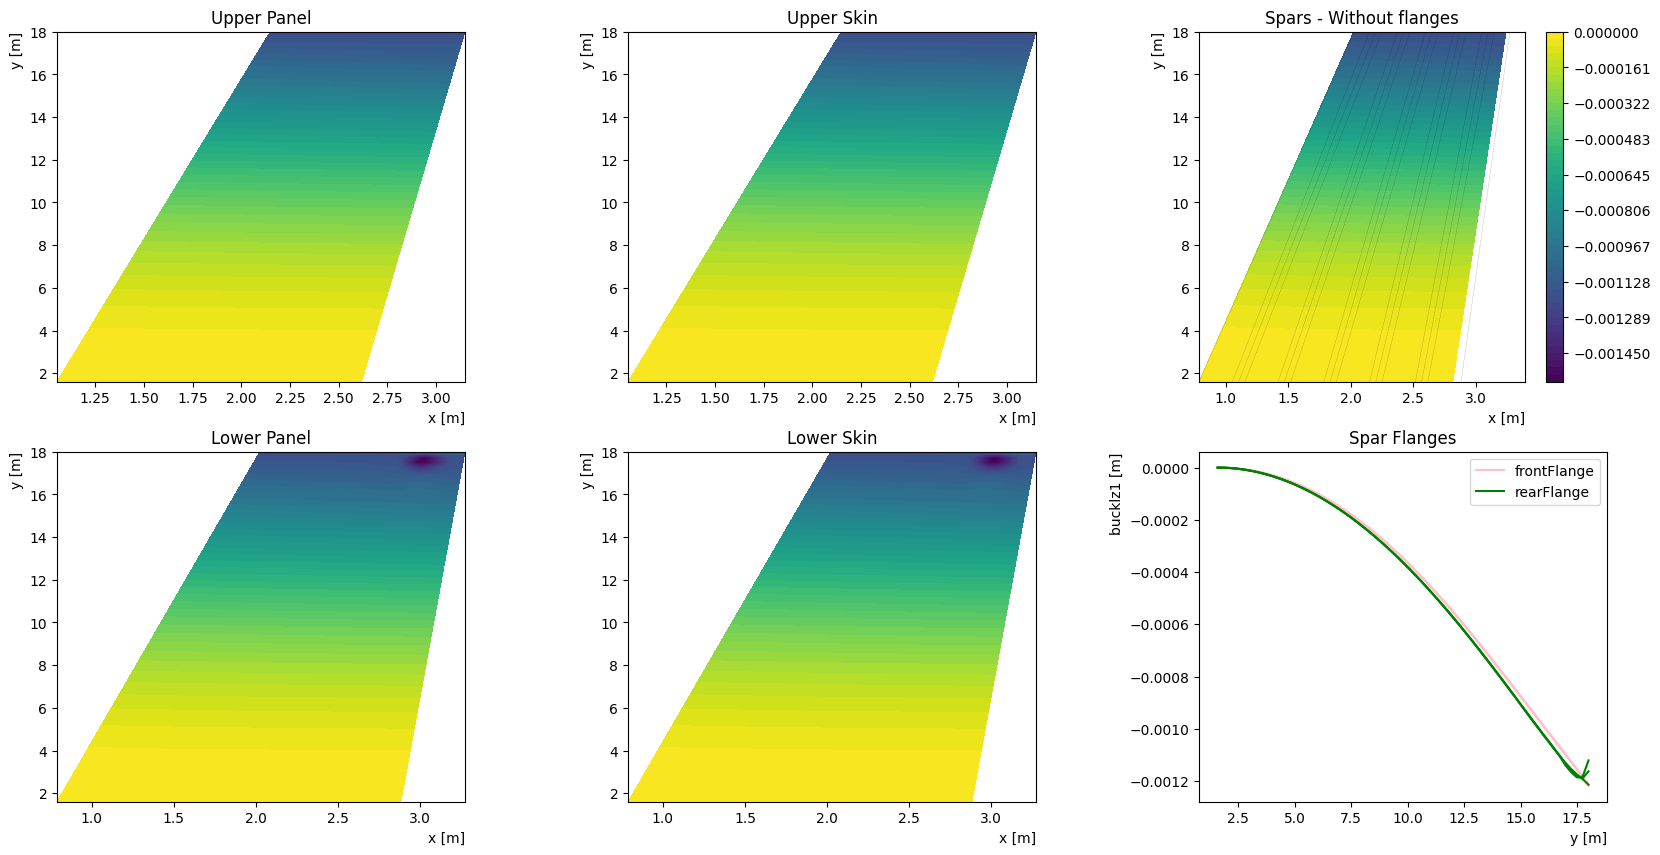

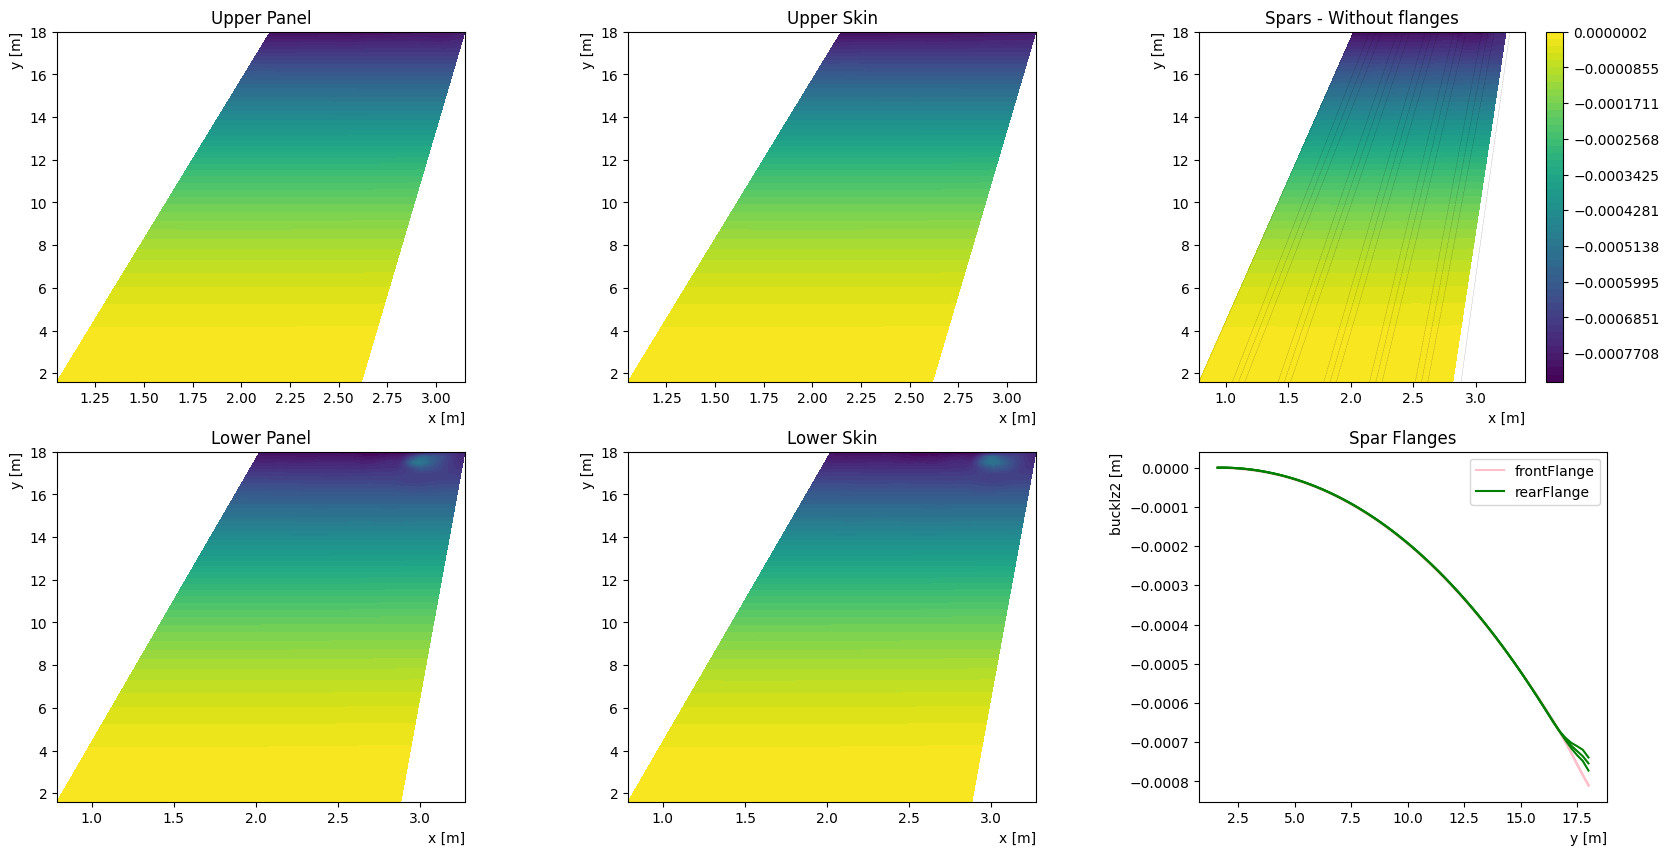

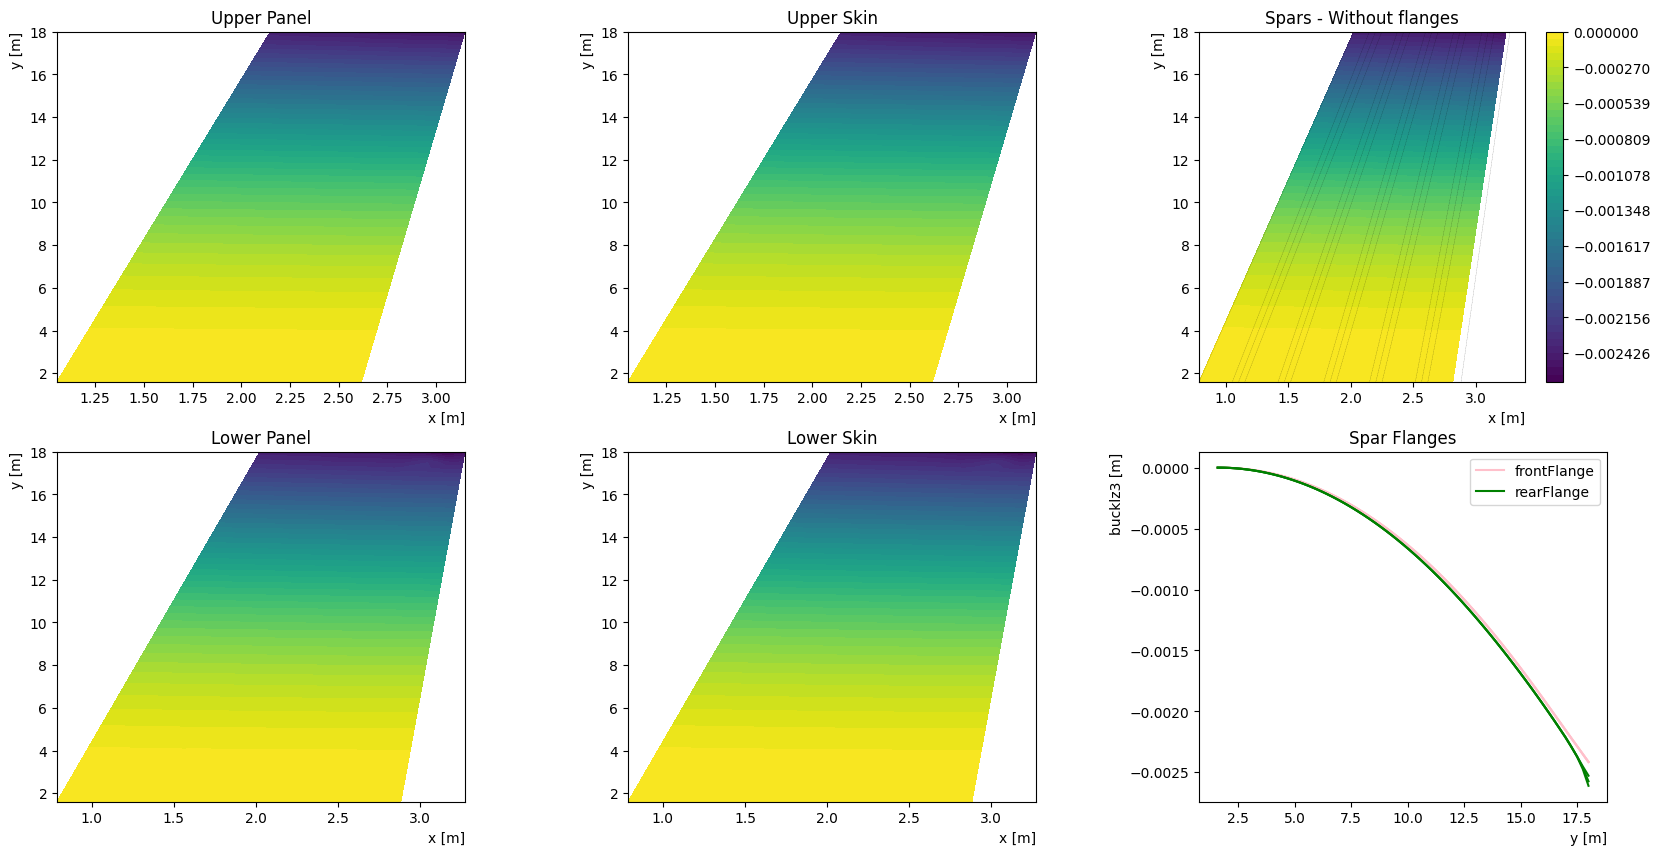

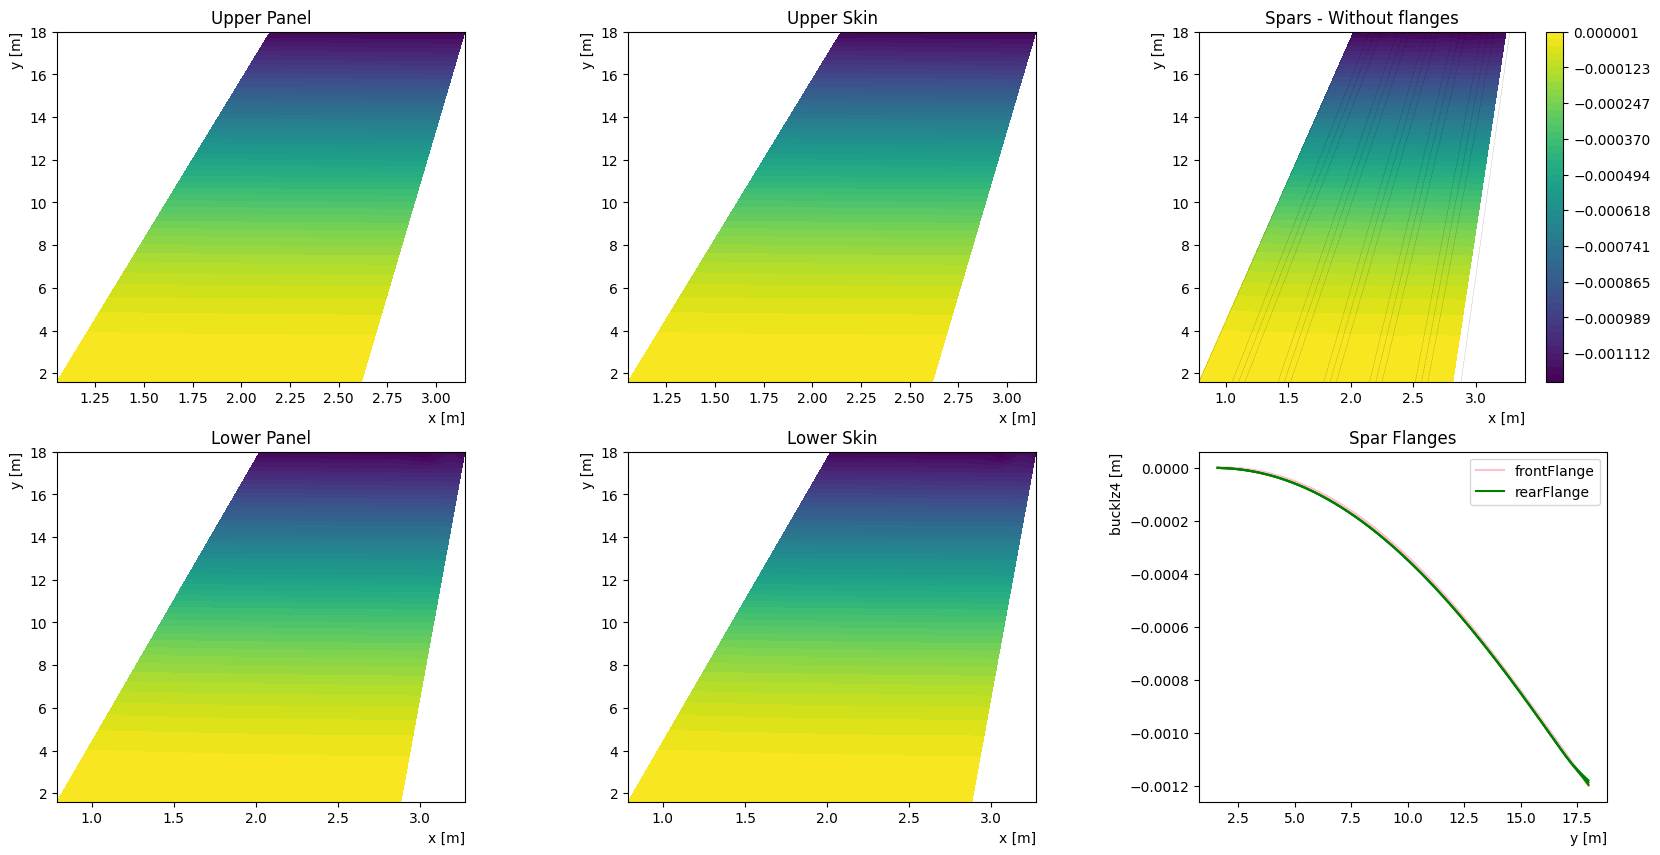

In [24]:
bl.plot_block(ppd["fi"][0::pf3.DOF], "Fi_x", meshOut, cst.CONSTS, "N")
bl.plot_block(ppd["fi"][1::pf3.DOF], "Fi_y", meshOut, cst.CONSTS, "N")
bl.plot_block(ppd["fi"][2::pf3.DOF], "Fi_z", meshOut, cst.CONSTS, "N")
bl.plot_block(ppd["fi"][3::pf3.DOF], "Mi_x", meshOut, cst.CONSTS, "N")
bl.plot_block(ppd["fi"][4::pf3.DOF], "Mi_y", meshOut, cst.CONSTS, "N")
bl.plot_block(ppd["fi"][5::pf3.DOF], "Mi_z", meshOut, cst.CONSTS, "N")
bl.plot_block(ppd["eigvecs"][0::pf3.DOF, 0], "bucklx1", meshOut, cst.CONSTS)
bl.plot_block(ppd["eigvecs"][0::pf3.DOF, 1], "bucklx2", meshOut, cst.CONSTS)
bl.plot_block(ppd["eigvecs"][0::pf3.DOF, 2], "bucklx3", meshOut, cst.CONSTS)
bl.plot_block(ppd["eigvecs"][0::pf3.DOF, 3], "bucklx4", meshOut, cst.CONSTS)
bl.plot_block(ppd["eigvecs"][2::pf3.DOF, 0], "bucklz1", meshOut, cst.CONSTS)
bl.plot_block(ppd["eigvecs"][2::pf3.DOF, 1], "bucklz2", meshOut, cst.CONSTS)
bl.plot_block(ppd["eigvecs"][2::pf3.DOF, 2], "bucklz3", meshOut, cst.CONSTS)
bl.plot_block(ppd["eigvecs"][2::pf3.DOF, 3], "bucklz4", meshOut, cst.CONSTS)
print(ppd["eigvals"])
print(ppd["load_mult"])
print(ppd["omegan"])

# Sizer

In [ ]:

@ftl.lru_cache
def _function(sizerVars:ty.Dict[str, object]):
    '''to be called to run the mesh'''
    eleDict = ed.eledict(cst.CONSTS, sizerVars, cst.CODES)
    meshOut = bl.mesh_block(cadData, sizerVars, eleDict, cst.CONSTS, cst.CODES)
    lfems, lppcs = list(), list()
    for lc in cst.LOAD_C:
        femres = bl.fem_linear_block(cst.CONSTS, meshOut, lc)
        lfems.append(femres)
        lppcs.append(post_processor_block(femres, meshOut, cst.CODES, sizerVars, cst.CONSTS))


def sizer_block(sizerVars:ty.Dict[str, object], meshOut:ty.Dict[str, object]):
    pass